# Softmax model

In this section, we will train a simple softmax model that predicts whether a given user has listened to an artist.
The model will take as input a feature vector $x$ representing the list of artists the user has listened to. Softmax, sometimes referred to as multinomial logistic regression, is a form of logistic regression. Softmax treats the problem as a multiclass prediction problem and will calculate the probability a user has listened to a certain song.

## Outline
  1. Batch Generation
  1. Loss Function
  1. Build, Train, Inspect

## Create DataFrame

In [ ]:
listened_artists = (listens[["userID", "artistID"]]
                .groupby("userID", as_index=False)
                .aggregate(lambda x: list(x.apply(str))))
listened_artists.userID = listened_artists.userID.astype('str')
listened_artists.head()

userID                                           artistID
0      0  [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5...
1      1  [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, ...
2     10  [66, 183, 185, 224, 282, 294, 327, 338, 371, 3...
3    100  [597, 610, 735, 739, 744, 746, 747, 763, 769, ...
4   1000  [49, 50, 58, 59, 61, 65, 83, 251, 282, 283, 28...

## Batch generation

We then create a function that generates an example batch, such that each example contains the following features:
- artistID: A tensor of strings of the artist ids that the user listened to.
- tag: A tensor of strings of the tags of those artists
- year: A tensor of strings of the peak year.

In [ ]:
years_dict = {
    artist: year for artist, year in zip(artists_df["id"], artists_df["peak_year"])
}
tags_dict = {
    artist: tags
    for artist, tags in zip(artists_df["id"], artists_df["all_tags"])
}

def make_batch(listens, batch_size):
  """Creates a batch of examples.
  Args:
    listens: A DataFrame of ratings such that examples["artistID"] is a list of
      artists listened to by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  artist = []
  year = []
  tag = []
  label = []
  for artistIDs in listens["artistID"].values:
    artist.append(artistIDs)
    tag.append([x for artistID in artistIDs for x in tags_dict[artistID]])
    year.append([years_dict[artistID] for artistID in artistIDs])
    label.append([int(artistID) for artistID in artistIDs])
  features = {
      "id": pad(artist, ""),
      "peak_year": pad(year, ""),
      "tag_1": pad(tag, ""),
      "label": pad(label, -1)
  }
  print('making batch')
  global tmp
  tmp = features
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())

  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

## Loss function
Tthe softmax model maps the input features $x$ to a user embedding $\psi(x) \in \mathbb R^d$, where $d$ is the embedding dimension. This vector is then multiplied by an artist embedding matrix $V \in \mathbb R^{m \times d}$ (where $m$ is the number of artists), and the final output of the model is the softmax of the product
$$
\hat p(x) = \text{softmax}(\psi(x) V^\top).
$$
Given a target label $y$, if we denote by $p = 1_y$ a one-hot encoding of this target label, then the loss is the cross-entropy between $\hat p(x)$ and $p$.

We will write a function that takes tensors representing the user embeddings  ψ(x) , movie embeddings  V , target label  y , and return the cross-entropy loss.

In [ ]:
def softmax_loss(user_embeddings, artist_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    artist_embeddings: A tensor of shape [num_artists, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1]
  artist_emb_dim = artist_embeddings.shape[1]
  if user_emb_dim != artist_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the artist embedding "
        "dimension % d" % (user_emb_dim, artist_emb_dim))

  logits = tf.matmul(user_embeddings, artist_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

## Build a softmax model, train it, and inspect its embeddings.

We are now ready to build a softmax CFModel. The architecture of the model is defined in the function `create_user_embeddings` and illustrated in the figure below. The input embeddings (artistID, tag_1 and peak_year) are concatenated to form the input layer, then we have hidden layers with dimensions specified by the `hidden_dims` argument. Finally, the last hidden layer is multiplied by the artist embeddings to obtain the logits layer. For the target label, we will use a randomly-sampled artistID from the list of artists the user has listened to.

![Softmax model](.\\softmax_schematic.png)

### Build

In [ ]:
def build_softmax_model(listened_artists, embedding_cols, hidden_dims):
  """Builds a Softmax model for lastfm.
  Args:
    listened_artists: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1]
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_listened_artists, test_listened_artists = split_dataframe(listened_artists)
  train_batch = make_batch(train_listened_artists, 200)
  test_batch = make_batch(test_listened_artists, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    artist_embeddings = tf.get_variable(
        "input_layer/id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, artist_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, artist_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, artist_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"artistID": artist_embeddings}
  return CFModel(embeddings, train_loss, metrics)

### Train

We are now ready to train the softmax model. The following hyperparameters can be set:
- learning rate
- number of iterations. Note: you can run `softmax_model.train()` again to continue training the model from its current state.
- input embedding dimensions (the `input_dims` argument)
- number of hidden layers and size of each layer (the `hidden_dims` argument)

Note: since our input features are string-valued (artistID, tag_1, and peak_year), we need to map them to integer ids. This is done using [`tf.feature_column.categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list), which takes a vocabulary list specifying all the values the feature can take. Then each id is mapped to an embedding vector using [`tf.feature_column.embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column).


In [ ]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(artists_df[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      listened_artists,
      embedding_cols=[
          make_embedding_col("id", 35),
          # make_embedding_col("tag", 3),
          # make_embedding_col("peak_year", 2),
      ],
      hidden_dims=[35])

making batch


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 iteration 3000: train_loss=6.966783, test_loss=7.547706, test_precision_at_10=0.007220

({'test_loss': 7.5477057, 'train_loss': 6.966783},
 {'test_precision_at_10': 0.007219926691102965})

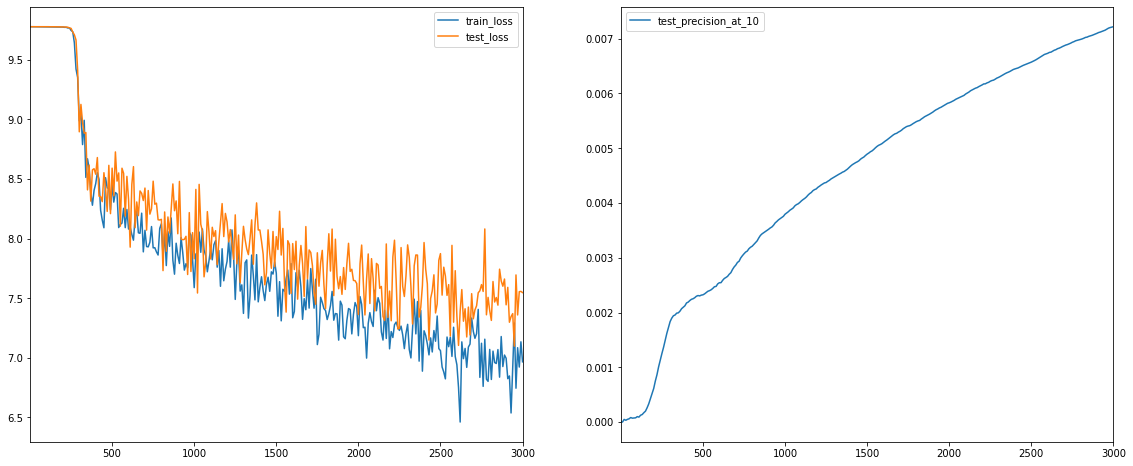

In [ ]:
softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)
# change iterations to 3000

The train loss is higher than the loss seen in previous models. Precision does improve with more training, however it remains low, reaching a maximum value of 0.0072. Precision for recommender systems is generally low as we are predicting items users might be interested in out of a large set of items. It is hard to tell if a user would actually be interested in an item if it is never presented to them as an option.

### Inspect Embeddings

We can inspect the artist embeddings as we did for the previous models. Note that in this case, the artist embeddings are used at the same time as input embeddings (for the bag of words representation of the user listening history), and as softmax weights.

In [ ]:
artist_neighbors(softmax_model, "Coldplay", DOT)
artist_neighbors(softmax_model, "Coldplay", COSINE)

Nearest neighbors of : Coldplay.
[Found more than one matching artist. Other candidates: Jay-Z & Coldplay, Coldplay/U2]


dot score                  names
59      36.792               Coldplay
223     33.686            The Killers
184     32.686                   Muse
527     31.506                  Oasis
214     31.132  Red Hot Chili Peppers
201     29.505         Arctic Monkeys

Nearest neighbors of : Coldplay.
[Found more than one matching artist. Other candidates: Jay-Z & Coldplay, Coldplay/U2]


cosine score              names
59           1.000           Coldplay
1366         0.950        Snow Patrol
223          0.939        The Killers
310          0.925  Alanis Morissette
527          0.923              Oasis
165          0.913      Stereophonics

## Conclusion

These recommendations are highly relevant. Although the loss is hihger,in my opinion the recommendations are superior to the recommendations we were receiving using the previous matrix factorization moodels. We have expanded on our previous work by building a softmax model that is capable of making relevant high quality recommendations.